<a href="https://colab.research.google.com/github/Altaieb-Mohammed/lab_2corse/blob/master/lab6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# -------------------------------------------------------------- Лабораторная работа №6: кластеризация и анализ качества

# Импортируем библиотеки для работы с данными, визуализацией и кластеризацией
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, OPTICS
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist

import warnings
warnings.filterwarnings('ignore')

# Загружаем данные с GitHub и выбираем числовые признаки для анализа
url = "https://raw.githubusercontent.com/Altaieb-Mohammed/lab_2corse/master/inheritance_combined.csv"
df = pd.read_csv(url)

feature_columns = [
    'debts', 'bequests', 'wife', 'husband',
    'sons', 'daughters', 'father', 'mother',
    'brothers', 'sisters'
]

# Выбираем признаки и заполняем пропуски медианой
X = df[feature_columns].copy()
X.fillna(X.median(), inplace=True)


In [ ]:
# Масштабируем признаки для корректной работы кластерных алгоритмов
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Метод локтя для выбора оптимального числа кластеров в KMeans
inertias = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.figure(figsize=(6, 5))
plt.plot(k_range, inertias, marker='o')
plt.title("Метод локтя для определения оптимального k")
plt.xlabel("Количество кластеров (k)")
plt.ylabel("Инерция (сумма квадратов расстояний)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# Запускаем KMeans с выбранным числом кластеров (3)
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Добавляем метки кластеров в исходный DataFrame
df_with_clusters = df.copy()
df_with_clusters['Cluster'] = clusters

# Выводим количество объектов в каждом кластере и примеры из кластеров
print("Количество объектов в каждом кластере:")
print(df_with_clusters['Cluster'].value_counts())

for i in range(3):
    print(f"\nПримеры из кластера {i}:")
    print(df_with_clusters[df_with_clusters['Cluster'] == i].head(5))


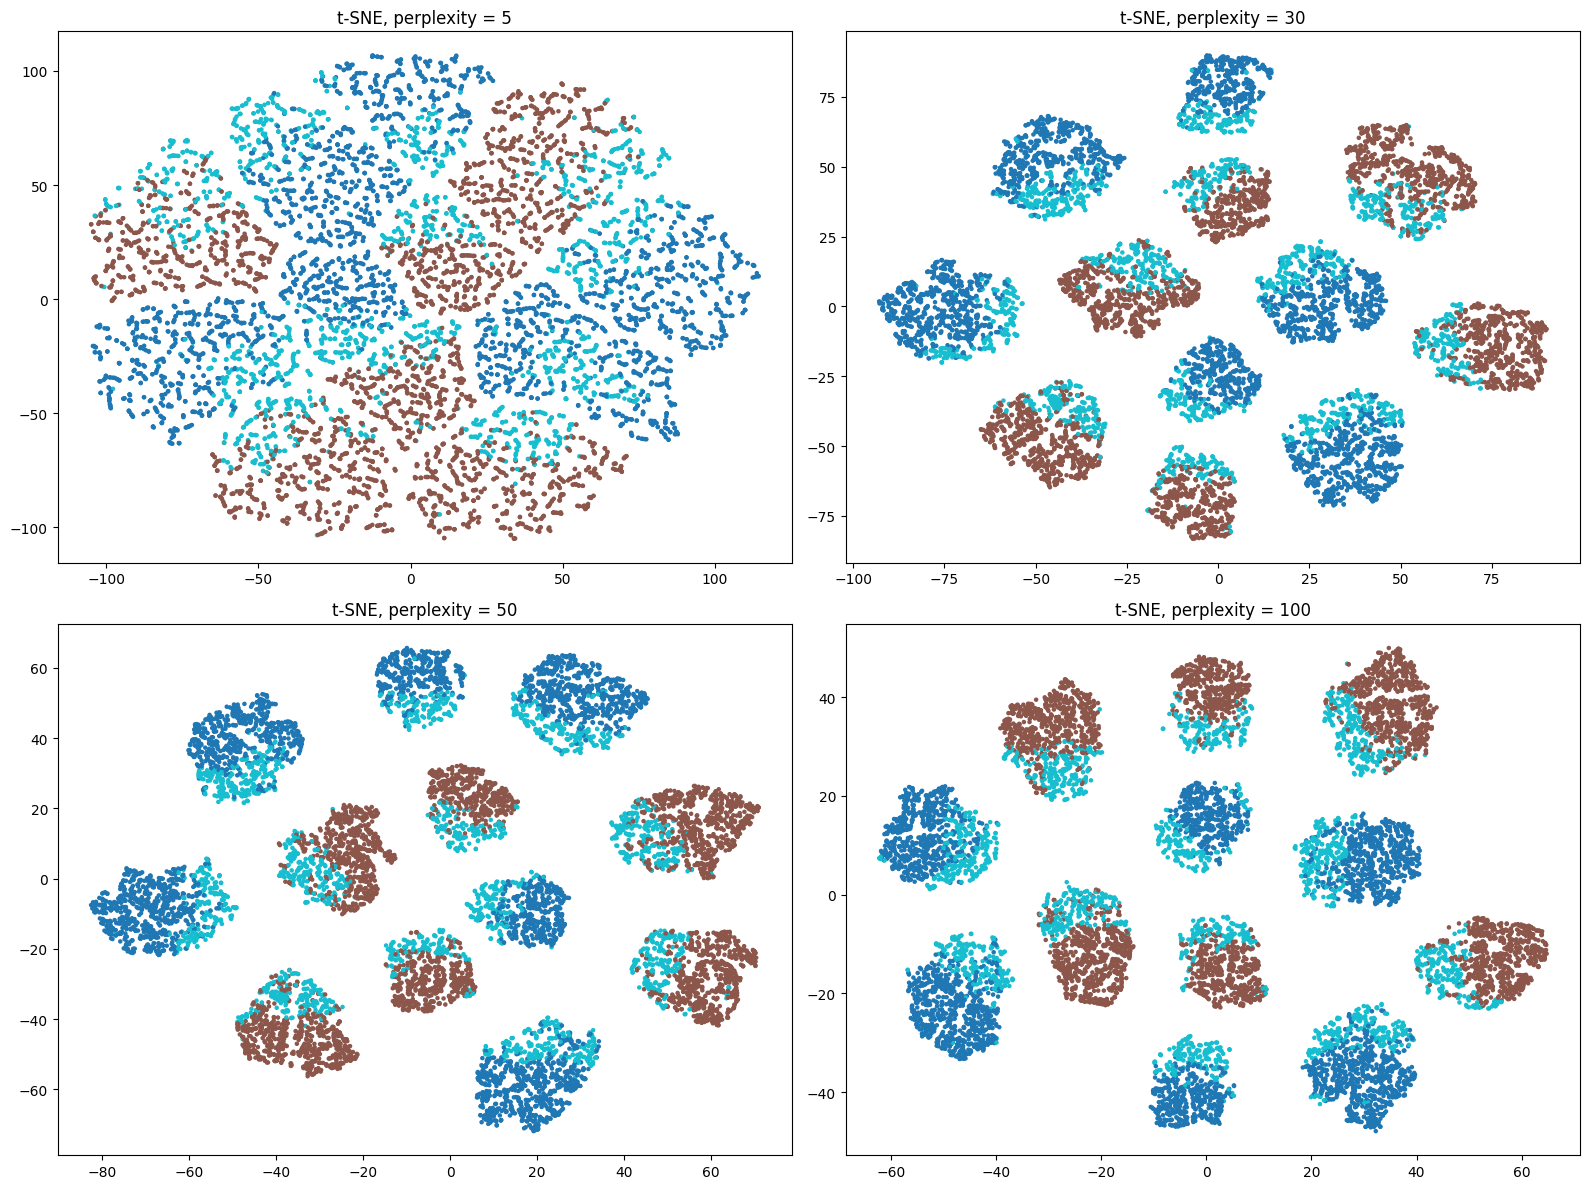

In [6]:
from sklearn.manifold import TSNE

# Визуализируем кластеры с помощью t-SNE при разных значениях perplexity
perplexities = [5, 30, 50, 100]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, p in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=p, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    labels = kmeans.labels_
    ax = axes[i // 2, i % 2]
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', s=5)
    ax.set_title(f"t-SNE, perplexity = {p}")

plt.tight_layout()
plt.show()


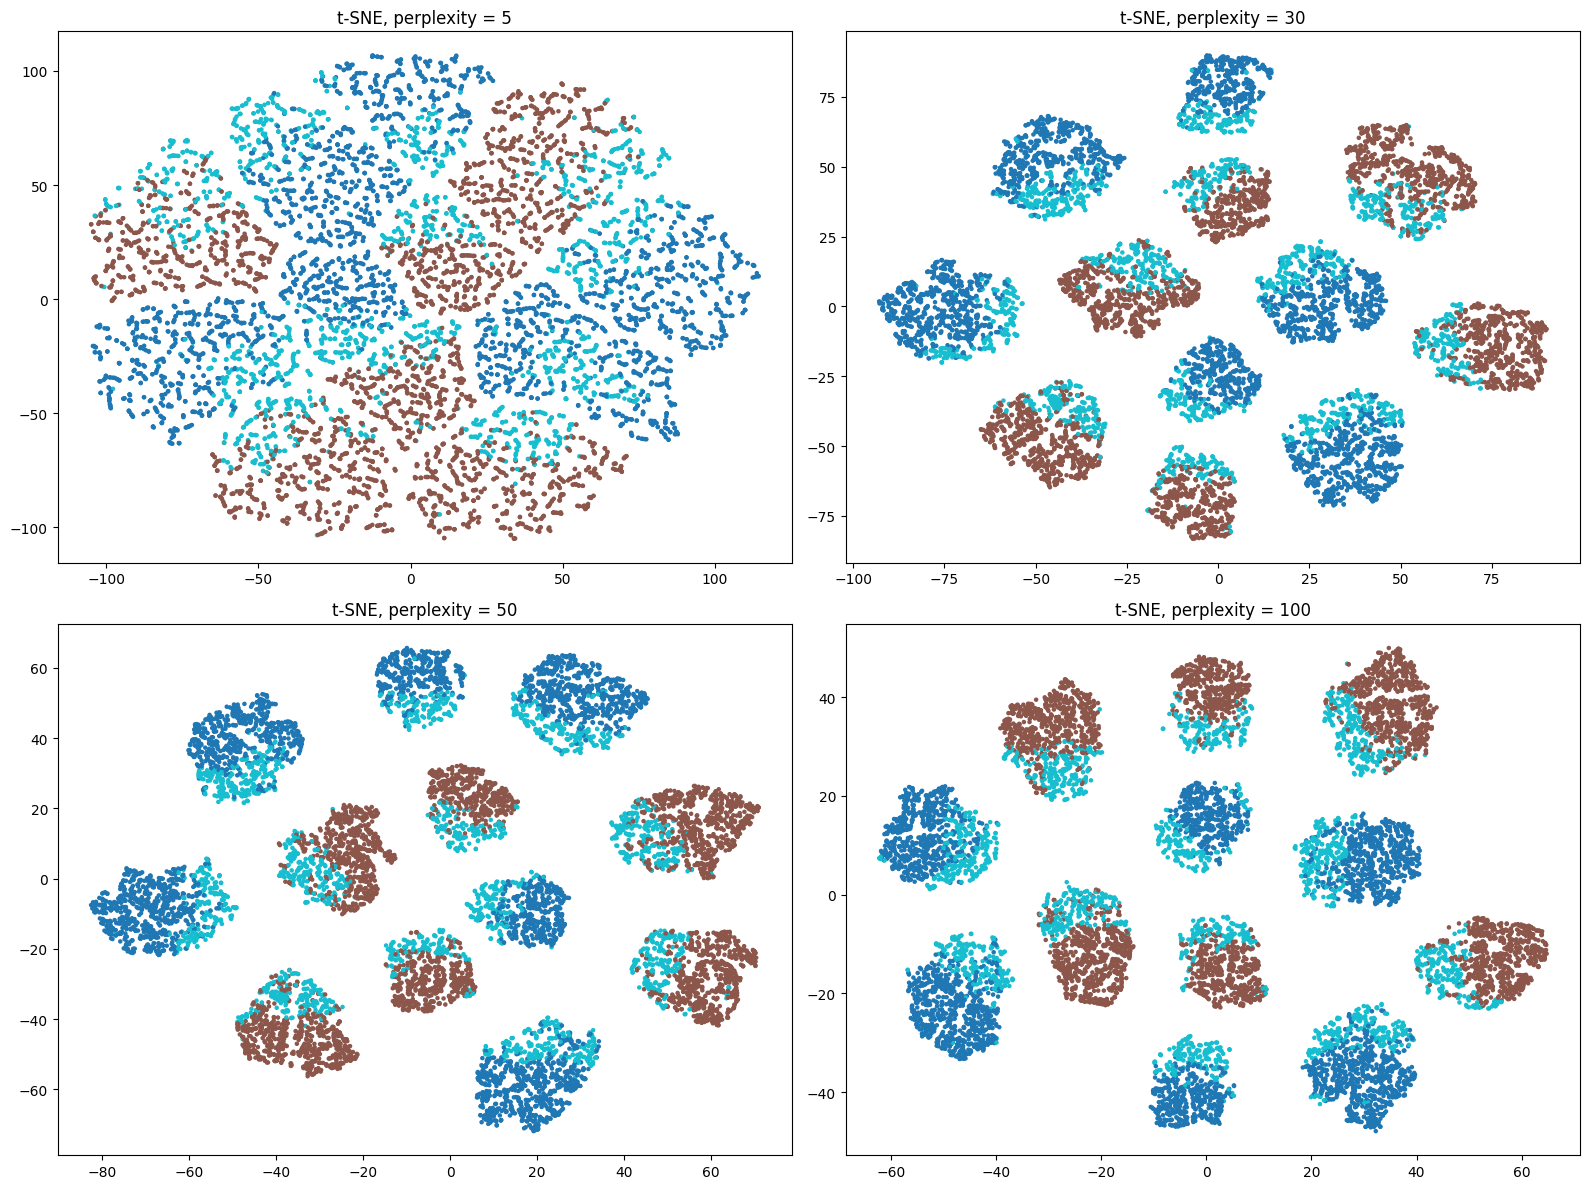

In [7]:
from sklearn.manifold import TSNE

# Визуализируем кластеры с помощью t-SNE при разных значениях perplexity
perplexities = [5, 30, 50, 100]
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for i, p in enumerate(perplexities):
    tsne = TSNE(n_components=2, perplexity=p, random_state=42)
    X_tsne = tsne.fit_transform(X_scaled)
    labels = kmeans.labels_
    ax = axes[i // 2, i % 2]
    scatter = ax.scatter(X_tsne[:, 0], X_tsne[:, 1], c=labels, cmap='tab10', s=5)
    ax.set_title(f"t-SNE, perplexity = {p}")

plt.tight_layout()
plt.show()


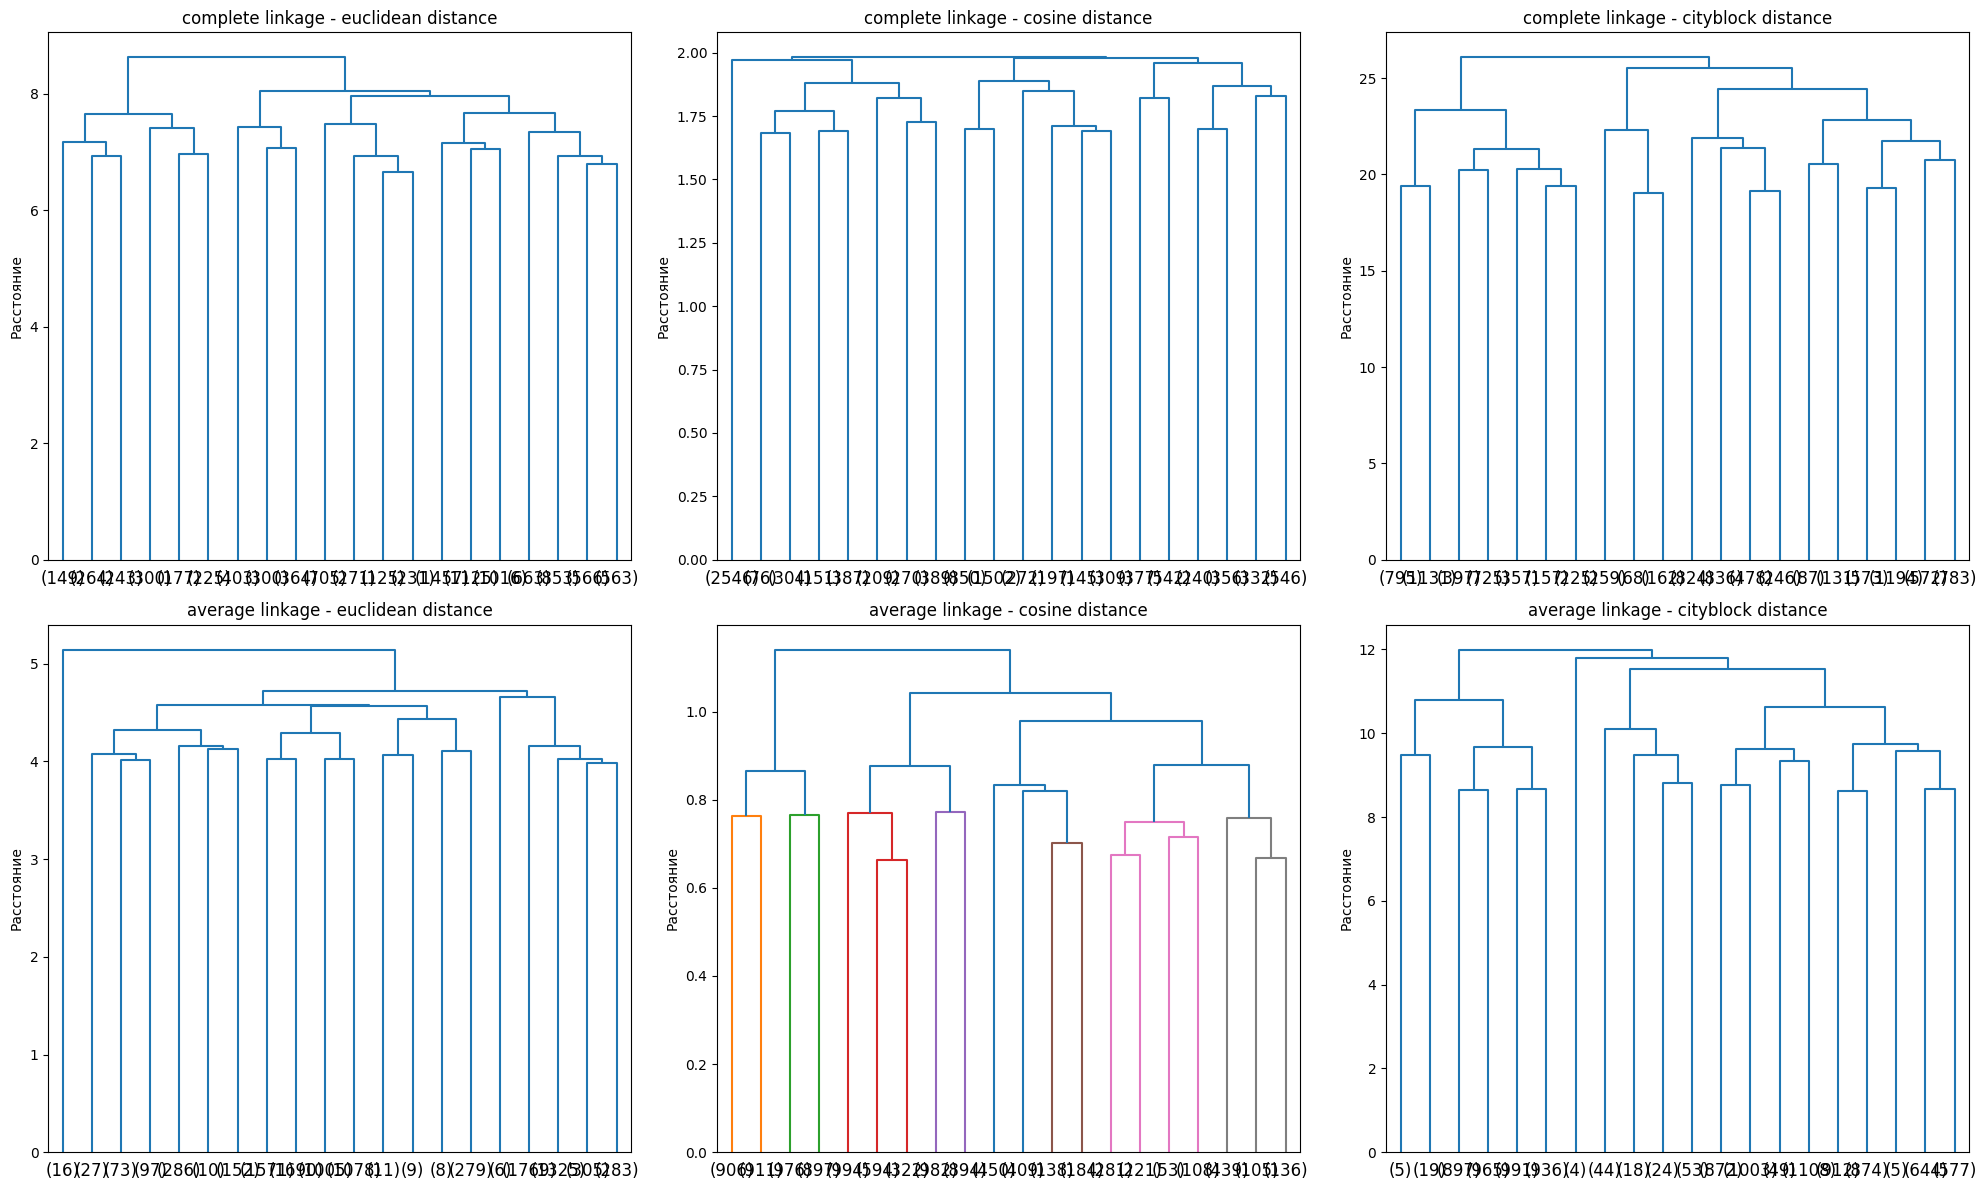

In [9]:
# Строим дендрограммы с разными методами агломерации и метриками расстояний
methods = ['complete', 'average']
metrics = ['euclidean', 'cosine', 'cityblock']

fig, axes = plt.subplots(len(methods), len(metrics), figsize=(20, 12))
for i, method in enumerate(methods):
    for j, metric in enumerate(metrics):
        ax = axes[i, j]
        Z = linkage(X_scaled, method=method, metric=metric)
        dendrogram(Z, ax=ax, truncate_mode='lastp', p=20)
        ax.set_title(f"{method} linkage - {metric} distance")
        ax.set_ylabel("Расстояние")
plt.tight_layout()
plt.show()


In [ ]:
# Агломеративная кластеризация с 3 кластерами и визуализация по первым двум признакам
agg_cluster = AgglomerativeClustering(n_clusters=3, metric='euclidean', linkage='ward')
clusters_agg = agg_cluster.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters_agg, cmap='Set1')
plt.title("Агломеративная кластеризация (по первым двум признакам)")
plt.xlabel("Признак 1 (масштабированный)")
plt.ylabel("Признак 2 (масштабированный)")
plt.grid(True)
plt.show()


In [ ]:
# Перебираем параметры eps и min_samples для DBSCAN с разными метриками
eps_values = np.arange(0.5, 2.1, 0.1)
min_samples_values = range(3, 11)
metrics_list = ['euclidean', 'manhattan']
results = []

for metric in metrics_list:
    for eps in eps_values:
        for min_samples in min_samples_values:
            db = DBSCAN(eps=eps, min_samples=min_samples, metric=metric)
            labels = db.fit_predict(X_scaled)
            mask = labels != -1
            n_clusters = len(set(labels[mask]))
            n_noise = np.sum(labels == -1)
            if n_clusters > 1:
                silhouette = silhouette_score(X_scaled[mask], labels[mask])
                calinski = calinski_harabasz_score(X_scaled[mask], labels[mask])
                davies = davies_bouldin_score(X_scaled[mask], labels[mask])
            else:
                silhouette, calinski, davies = -1, np.nan, np.nan
            results.append({
                'metric': metric,
                'eps': round(eps, 2),
                'min_samples': min_samples,
                'n_clusters': n_clusters,
                'n_noise': n_noise,
                'silhouette': silhouette,
                'calinski': calinski,
                'davies_bouldin': davies
            })

df_dbscan = pd.DataFrame(results)
df_dbscan.to_csv("dbscan_grid_search.csv", index=False)
print("\nТоп-10 по silhouette (DBSCAN):")
print(df_dbscan.sort_values(by='silhouette', ascending=False).head(10))


In [ ]:
# Функция для вычисления индекса Данна для оценки качества кластеризации
def dunn_index(X, labels):
    unique_clusters = np.unique(labels)
    clusters = [np.where(labels == c)[0] for c in unique_clusters if c != -1]
    if len(clusters) < 2:
        return 0
    inter_cluster_dists = []
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            dist = cdist(X[clusters[i]], X[clusters[j]], metric='euclidean')
            inter_cluster_dists.append(np.min(dist))
    if len(inter_cluster_dists) == 0:
        return 0
    inter_cluster_dist = np.min(inter_cluster_dists)
    intra_cluster_diameters = []
    for cluster in clusters:
        if len(cluster) > 1:
            dists = cdist(X[cluster], X[cluster], metric='euclidean')
            intra_cluster_diameters.append(np.max(dists))
        else:
            intra_cluster_diameters.append(0)
    intra_cluster_diam = np.max(intra_cluster_diameters)
    return inter_cluster_dist / intra_cluster_diam if intra_cluster_diam else 0


In [ ]:
# Сравниваю KMeans, AgglomerativeClustering, DBSCAN и OPTICS по метрикам качества кластеризации
models = {
    "KMeans": KMeans(n_clusters=3, random_state=42, n_init=10),
    "AgglomerativeClustering": AgglomerativeClustering(n_clusters=3),
    "DBSCAN": DBSCAN(eps=0.9, min_samples=8),
    "OPTICS": OPTICS(min_samples=5)
}

silhouette_scores = {}
davies_bouldin_scores = {}
dunn_indices = {}
cluster_results = {}

for name, model in models.items():
    labels = model.fit_predict(X_scaled)
    mask = labels != -1
    silhouette_scores[name] = silhouette_score(X_scaled[mask], labels[mask]) if len(np.unique(labels[mask])) > 1 else 0
    davies_bouldin_scores[name] = davies_bouldin_score(X_scaled[mask], labels[mask]) if len(np.unique(labels[mask])) > 1 else np.nan
    dunn_indices[name] = dunn_index(X_scaled, labels)
    cluster_results[name] = labels

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].bar(silhouette_scores.keys(), silhouette_scores.values(), color="skyblue")
axes[0].set_title("Silhouette Score")
axes[1].bar(davies_bouldin_scores.keys(), davies_bouldin_scores.values(), color="salmon")
axes[1].set_title("Davies-Bouldin Index")
axes[2].bar(dunn_indices.keys(), dunn_indices.values(), color="lightgreen")
axes[2].set_title("Dunn Index")
plt.tight_layout()
plt.show()
